# Boosting and Stacking

We will be using the Human Activity Recognition with Smartphones database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided:

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial angular velocity from the gyroscope.
- A 561-feature vector with time and frequency domain variables.
- Its activity label.

More information about the features, and the data source is available on the website below:

https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones#

# Importing the Libraries

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

# Importing the Dataset

In [2]:
dataset = 'Human_Activity_Recognition_Using_Smartphones_Data.csv'
ds = pd.read_csv(dataset)

In [3]:
# We see that the data has quite a few predictor columns.

ds.shape

(10299, 562)

In [4]:
# The only non-float is the categories column, which is the predicted column.

ds.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [5]:
# Taking care of missing data
# We observe that there are no missing values

ds.isnull().sum().value_counts()

0    562
dtype: int64

In [6]:
ds.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,...,0.126708,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,...,0.245443,0.320199,0.308796,0.336591,0.447364,0.616188,0.484770,0.511158,0.305468,0.268898
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262625,-0.024902,-0.121019,-0.992360,-0.976990,-0.979137,-0.993293,-0.977017,-0.979064,-0.935788,...,-0.019481,-0.536174,-0.841847,-0.124694,-0.287031,-0.493108,-0.389041,-0.817288,0.002151,-0.131880
50%,0.277174,-0.017162,-0.108596,-0.943030,-0.835032,-0.850773,-0.948244,-0.843670,-0.845068,-0.874825,...,0.136245,-0.335160,-0.703402,0.008146,0.007668,0.017192,-0.007186,-0.715631,0.182028,-0.003882
75%,0.288354,-0.010625,-0.097589,-0.250293,-0.057336,-0.278737,-0.302033,-0.087405,-0.288149,-0.014641,...,0.288960,-0.113167,-0.487981,0.149005,0.291490,0.536137,0.365996,-0.521503,0.250790,0.102970
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the below (and above), we observe that the minimum and maximum value for the float columns is -1.0 and 1.0, respectively. However, scaling is never required for tree-based methods. As this notebook also regards Stacking, for Stacking methods it is beneficial to use scaling as we are not limited to using tree-based methods.

In [7]:
float_columns = (ds.dtypes == np.float)

# Verify that the maximum of all float columns is 1.0
print((ds.loc[:,float_columns].max()== 1.0).all())

# Verify that the minimum of all float columns is -1.0
print((ds.loc[:,float_columns].min()== -1.0).all())

True
True


# Encoding the Categorical Variables

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

ds['Activity'] = le.fit_transform(ds['Activity'])

le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [9]:
ds.Activity.unique()

array([2, 1, 0, 3, 4, 5])

# Splitting the Dataset into the Training Set and Test Set

We will now split the dataset into the training set and test set. A stratified split was not used here. If there are issues with any of the error metrics on the test set, it can be a good idea to start model fitting over using a stratified split. Boosting is a pretty powerful model, so it may not be necessary in this case.

In [10]:
ds.Activity.value_counts(normalize = True)

0    0.188756
2    0.185067
1    0.172541
3    0.167201
5    0.149917
4    0.136518
Name: Activity, dtype: float64

In [11]:
from sklearn.model_selection import train_test_split

feature_columns = [x for x in ds.columns if x != 'Activity']

X_train, X_test, y_train, y_test = train_test_split(ds[feature_columns], ds['Activity'],
                                                    test_size = 0.3, random_state = 42)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7209, 561), (7209,), (3090, 561), (3090,))

# Fitting the Models to the Dataset

We will now:

- Fit gradient boosted tree models with all parameters set to their defaults following tree numbers `(n_estimators = [15, 25, 50, 100, 200, 400])` and evaluate the accuracy on the test data for each of these models.
- Plot the accuracy as a function of estimator number.

Note: There is no out-of-bag error for boosted models. And the `warm_flag = True` setting has a bug in the gradient boosted model, so we will not use it. We'll simply create the model inside the `for loop` and set the number of estimators at a time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

**Note: The below code took a long time to run, I left it running overnight.**

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees
Fitting model with 400 trees


,error
n_trees,
15.0,0.051133
25.0,0.033981
50.0,0.019417
100.0,0.013592
200.0,0.011003
400.0,0.010356


As we increased the number of trees, we see the error diminishing. This is observed graphically below.

In [14]:
error_df

,error
n_trees,
15.0,0.051133
25.0,0.033981
50.0,0.019417
100.0,0.013592
200.0,0.011003
400.0,0.010356


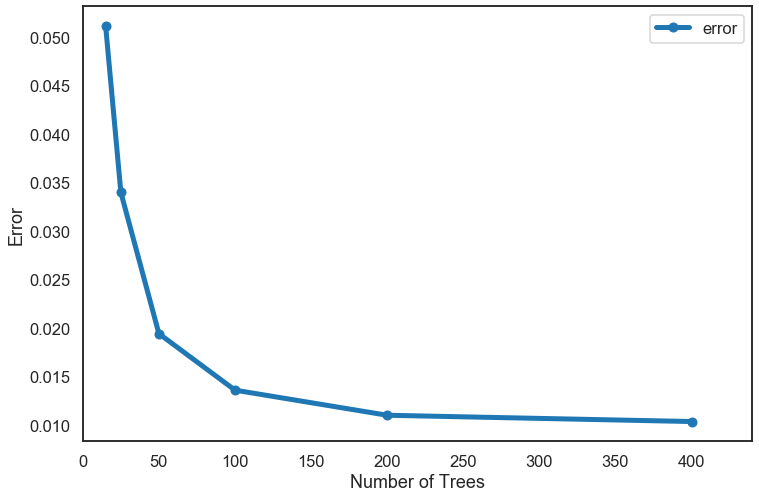

In [15]:
sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

We will now:

- Use a grid search with cross-validation and fit a new gradient boosted classifier with the same list of estimators as the steps above. Also, we will try varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, ... etc).
- Examine the parameters of the best fit model.
- Calculate relevant error metrics on this model and examine the confusion matrix.

**Note:** The lower the learning rate, the higher the number of trees we wish to have or vice versa. 

In [16]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In the below step, we are performing pickling. Here, we serialise our Python objects and save them as bytes, so they are saved in a file. If we wish to introduce them as Python objects again, we can pull them out using the pickle functionality. This works by doing `pickle.dump` and thats just dumping our Python objects into a pickle file.

In [44]:
import pickle

pickle.dump(GV_GBC, open('gv_gbc.p', 'wb')) # w - write, b - bytes

GV_GBC = pickle.load(open('gv_gbc.p', 'rb')) # r - read, b - bytes

In [18]:
print(GV_GBC.best_estimator_)
print(GV_GBC.best_params_)
print(GV_GBC.best_score_)

GradientBoostingClassifier(max_features=4, n_estimators=400, random_state=42)
{'learning_rate': 0.1, 'max_features': 4, 'n_estimators': 400, 'subsample': 1.0}
0.9866833307506248


In [19]:
print(GV_GBC.best_estimator_.learning_rate)

0.1


In [20]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.97      0.97      0.97       561
           2       0.97      0.97      0.97       547
           3       1.00      1.00      1.00       540
           4       1.00      1.00      1.00       419
           5       1.00      0.99      0.99       426

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[597   0   0   0   0   0]
 [  0 544  17   0   0   2]
 [  0  17 530   0   0   0]
 [  0   0   0 538   0   1]
 [  0   0   0   1 418   1]
 [  0   0   0   1   1 422]]


Similar to what we have done above, we will now:

- Create an AdaBoost model and fit it using grid search with a range of estimators between 100 and 200.
- Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

In [34]:
print(GV_ABC.best_estimator_)
print(GV_ABC.best_params_)
print(GV_ABC.best_score_)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01, n_estimators=100)
{'learning_rate': 0.01, 'n_estimators': 100}
0.712172160456456


**Note:** The issues with class 1 and 2 appear to have become more problematic. Also note other issues for classes 3 - 5. AdaBoost is very sensitive to outliers, so that could be the problem here.

In [35]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       600
           1       0.00      1.00      0.00         1
           2       1.00      0.49      0.66      1106
           3       0.92      0.84      0.88       589
           4       0.73      0.95      0.82       320
           5       0.89      0.80      0.84       474

    accuracy                           0.75      3090
   macro avg       0.76      0.85      0.70      3090
weighted avg       0.94      0.75      0.81      3090



In [36]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[597   0   0   0   0   0]
 [  1   1 561   0   0   0]
 [  2   0 545   0   0   0]
 [  0   0   0 497   6  36]
 [  0   0   0  55 305  60]
 [  0   0   0  37   9 378]]


# Stacking

In the following steps, we will now:
    
- Fit a logistic regression model with regularization.
- Using `VotingClassifier`, fit the logistic regression model along with either the GradientBoostedClassifier or the AdaBoost model (or both) from the above steps.
- Determine the error as before and compare the results to the appropriate gradient boosted model(s).
- Plot the confusion matrix for the best model.

In [37]:
from sklearn.linear_model import LogisticRegression

# L2 regularised logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)

In [38]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       0.95      0.96      0.95       558
           2       0.95      0.95      0.95       547
           3       1.00      0.99      0.99       544
           4       0.98      1.00      0.99       413
           5       1.00      0.98      0.99       430

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



In [39]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[597   0   0   0   0   0]
 [  1 533  25   0   0   4]
 [  0  25 522   0   0   0]
 [  0   0   0 538   0   1]
 [  0   0   0   4 413   3]
 [  0   0   0   2   0 422]]


**And now the Stacked model**

In [40]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

**Note:** Although we have not performed this step here, it is often desirable to train this model using an additional hold-out data set and/or with cross validation.

In [41]:
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

**Note:** The performance for the voting classifier should improve relative to either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder to try the simplest model first. In some cases, its performance will be good enough. This should be kept in mind in all business settings as time is crucial, and the tradeoff between model accuracy and time spent working on the model should be optimal.

In [42]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.97      0.96      0.97       563
           2       0.97      0.97      0.97       547
           3       1.00      1.00      1.00       539
           4       1.00      1.00      1.00       420
           5       0.99      1.00      0.99       424

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



In [43]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[597   0   0   0   0   0]
 [  0 540  19   0   0   4]
 [  0  16 531   0   0   0]
 [  0   0   0 538   0   1]
 [  0   0   0   1 419   0]
 [  0   0   0   1   0 423]]
